### Download data
The script downloads the oxford - iit - pet data

In [ ]:
# %run download_dataset.py

### Import libraries

In [1]:
import os

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pandas as pd
import numpy as np
import json
import albumentations as A
import matplotlib.pyplot as plt
from IPython.display import clear_output


from custom_losses import *
from custom_metrics import *
from unet import *

### Prepare data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
data_config = json.load(open('data/config.json'))

In [3]:
color_map = data_config['color_map']

train_img_paths = list(train_df['image_ids'].apply(lambda x: os.path.join('data','train', x+'_img.png')))
train_mask_paths = list(train_df['image_ids'].apply(lambda x: os.path.join('data','train', x+'_mask.png')))

test_img_paths = list(test_df['image_ids'].apply(lambda x: os.path.join('data','test', x+'_img.png')))
test_mask_paths = list(test_df['image_ids'].apply(lambda x: os.path.join('data','test', x+'_mask.png')))

In [4]:
transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.CLAHE(p = 0.5),
    A.RandomBrightnessContrast(p = 0.5),
    A.RandomGamma(p = 0.5),
    A.OneOf([
        A.Blur(p = 0.5),
        A.GaussianBlur(p = 0.5),
        A.MedianBlur(p = 0.5)
    ]),
    A.GaussNoise(p = 0.5)
    ])

In [5]:
def img_to_mask(mask_img):
    num_classes = len(color_map.keys())
    mask = np.ones((mask_img.shape[0], mask_img.shape[1], num_classes), np.uint8)
    for i in range(num_classes):
        mask[..., i] = np.alltrue(mask_img == color_map[str(i)], axis=2)
    return mask

def wrapper_img_to_mask(img, mask_img):
    mask = tf.numpy_function(func= img_to_mask, inp = [mask_img], Tout = tf.uint8)
    return img, mask

def augmentation(img, mask):
    data = {'image':img, 'mask':mask}
    data = transform(**data)
    return data['image'], data['mask']

def wrapper_augmentation(img, mask):
    img, mask = tf.numpy_function(func = augmentation, inp = [img, mask], Tout = [tf.uint8, tf.uint8])
    return img, mask

def read_data(img_path, mask_path):
    img = tf.io.read_file(img_path)
    mask = tf.io.read_file(mask_path)
    
    img = tf.io.decode_png(img, 3)
    mask = tf.io.decode_png(mask, 3)
    
    img = tf.image.resize(img, (128,128), method = 'nearest')
    mask = tf.image.resize(mask, (128,128), method = 'nearest')
    return img, mask

def normalize(img, mask):
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    img = img / 255.0
    return img, mask
    
_img, _mask = read_data(train_img_paths[0], train_mask_paths[0])
print(_img.shape, _mask.shape)

(128, 128, 3) (128, 128, 3)


In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths)).shuffle(5000)
test_ds = tf.data.Dataset.from_tensor_slices((test_img_paths, test_mask_paths)).shuffle(5000)

train_ds = train_ds.map(read_data).map(wrapper_img_to_mask).map(wrapper_augmentation).map(normalize).batch(16).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(read_data).map(wrapper_img_to_mask).map(normalize).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

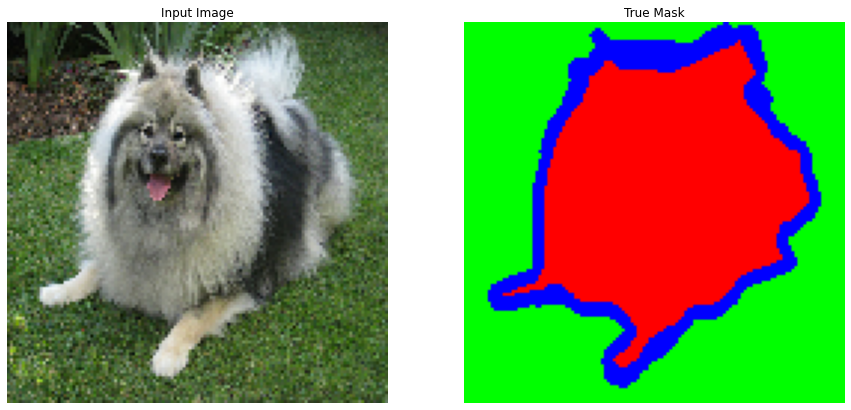

In [8]:
for image , mask in test_ds.take(1):
    sample_image, sample_mask = image[0], mask[0]

display([sample_image, sample_mask])

### Create Model

In [9]:
cwce = CustomWeightedCategoricalCrossentropy([1, 1.3, 0.7])
cmdl = CustomMyDiceLoss()
cdl = CustomDiceLoss()
ctl = CustomTverskyLoss()
cftl = CustomFocalTverskyLoss()
cldl = CustomLogDiceLoss()
def combined_loss_fn(y_true, y_pred):
    loss = cwce(y_true, y_pred) + cmdl(y_true, y_pred) + cdl(y_true, y_pred) + ctl(y_true, y_pred) + cftl(y_true, y_pred) + cldl(y_true, y_pred)
    return loss
    
loss_fn = combined_loss_fn

model = get_unet_128(num_classes = 3)
model.compile(optimizer = 'adam', loss = loss_fn, metrics = [CustomIOU(3)])

model.save('best_model.h5')
model = tf.keras.models.load_model('best_model.h5', custom_objects = {loss_fn.__name__:loss_fn, 'CustomIOU':CustomIOU})

In [10]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [11]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

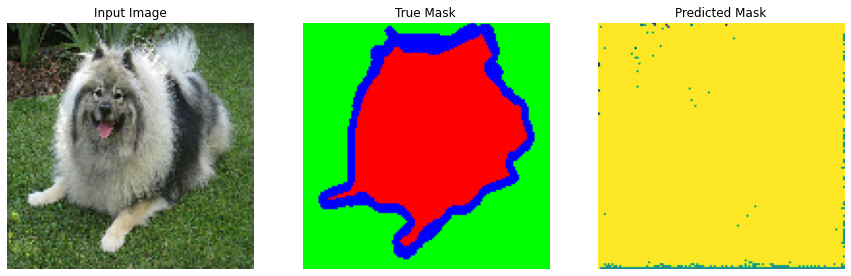

In [12]:
show_predictions()

In [13]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
             tf.keras.callbacks.ModelCheckpoint(monitor='val_weighted_iou',
                             filepath='best_model.h5',
                             save_best_only=True,
                             verbose = 1,
                             mode = 'max'
                             ),
#              tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch = 0), 
             DisplayCallback()
            ]

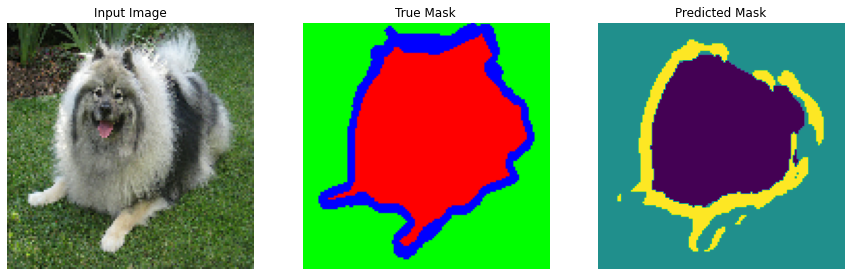


Sample Prediction after epoch 4

211/230 [==========================>...] - ETA: 21s - loss: 1.6088 - weighted_iou: 0.4926

KeyboardInterrupt: 

In [16]:
hist = model.fit(train_ds, epochs = 20, verbose = 1, callbacks = callbacks, validation_data = test_ds)

In [ ]:
model.evaluate(test_ds, verbose = 1)